In [1]:
## Import necessary stuff. 

# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Special imports
import utils
import logomaker

# JAX imports
import jax.numpy as jnp
import jax.random as random

# Numpyro imports
import numpyro
from numpyro.diagnostics import hpdi
from numpyro.infer import Predictive
import numpyro.distributions as dist

fig_name = 'figS12'
plt.style.use(f'../fig.style')

# generate random keys for training and predictions
rng_key, rng_key_predict = random.split(random.PRNGKey(0))

In [2]:
def load_data(sheet_name=None):
    # Name of excel file
    file_name = '../data/qPCR/control_dose_response_curves.xlsx'
    
    # Return sheet names if none specified
    if sheet_name is None:
        return pd.ExcelFile(file_name).sheet_names
    
    # Load data from Excel sheet
    data_df = pd.read_excel(file_name,
                            sheet_name=sheet_name, header=[0, 1], index_col=[0, 1])
    data_df.index.rename(['conc', 'bio_rep'], inplace=True)
    data_df.columns.rename(['primers', 'tech_rep'], inplace=True)

    # Pivot to make tidy data
    tidy_df = data_df.melt(value_name='cycles',
                           ignore_index=False).reset_index()
    
    # For each (conc, bio_rep) compute mean of cycles across tech_rep
    import pdb
    try:
        df = tidy_df.groupby(['conc','bio_rep','primers']).mean()['cycles'].to_frame().reset_index()
        df = df.pivot(index=['conc','bio_rep'],columns='primers', values='cycles')
    except:
        pdb.set_trace()

    # Compute dCt values (NOTE: exclusion - inclusion !)
    df['dCt'] = df['exclusion'] - df['inclusion']
    df = df.reset_index()[['conc','bio_rep','dCt']]
    df.columns.name = ''
    
    return df

In [3]:
def load_mcmc_samples(sheet_name):
    mcmc_file_name = f'../mcmc_samples/mcmc_{sheet_name}.pkl'
    with open(mcmc_file_name, 'rb') as f:
        mcmc_samples = pickle.load(f)
    return mcmc_samples

In [4]:
### MUST BE SAME AS IN INFERENCE SCRIPT
def single_drug_model(x, y=None):

    # Context strength
    log10_S = numpyro.sample("log10_S", dist.Uniform(low=-3, high=3))
    S=numpyro.deterministic('S', 10.0**log10_S)

    # Hill coefficient
    log2_H = numpyro.sample("log2_H", dist.Normal(loc=0, scale=2))
    H=numpyro.deterministic('H', 2.0**log2_H)

    # Normalizing concentration
    log10_NC = numpyro.sample("log10_NC", dist.Uniform(low=-3, high=3))
    NC=numpyro.deterministic('NC',10.0**log10_NC)

    # Measurement noise
    log10_sigma = numpyro.sample("log10_sigma", dist.Uniform(low=-2, high=2))
    sigma = numpyro.deterministic('sigma',10.0**log10_sigma)

    # Amplitude
    log10_alpha = numpyro.sample("log10_alpha", dist.Uniform(low=0, high=6))
    alpha = numpyro.deterministic('alpha',10.0**log10_alpha)
    
    # R = inclusion / exclusion
    R = numpyro.deterministic('R', S*(1 + (x/NC)**H)/(1 + (1/alpha)*(x/NC)**H))
    log2_R = numpyro.deterministic('log2_R', jnp.log2(R))
    numpyro.sample('yhat', dist.Normal(log2_R, sigma), obs=y)

In [5]:
EC2x = {'risdiplam': 14,
        'branaplam': 7,
        'ASOi6': 0.6,
        'ASOi7': 0.1,
        'RECTAS': 0.2,
        'ASOi20': 0.08}

In [6]:
def plot_data(ax, x, y, x_left):
    ix = x>0
    ax.scatter(x[ix], 
               y[ix], 
               s=10,
               alpha=.5,
               color='k', 
               zorder=100,
               linewidth=0)
    n_zero = sum(~ix)
    x_zero = x_left*np.ones(n_zero)
    y_zero = y[~ix]
    ax.scatter(x_zero,
               y_zero,
               marker='<',
               s=10,
               alpha=.5,
               color='k', 
               zorder=100,
               linewidth=0)

In [7]:
def log_ticks_from_lims(lim):   
    # Compute xticks and yticks
    log_tick_lo = np.ceil(np.log10(lim[0])).astype(int)
    log_tick_hi = np.floor(np.log10(lim[1])).astype(int)
    ticks = [10**tick for tick in range(log_tick_lo, log_tick_hi+1)]
    return ticks
    
log_ticks_from_lims([1E-3, 1E3])

[0.001, 0.01, 0.1, 1, 10, 100, 1000]

In [8]:
def plot_single_drug(ax,
                     minigene,
                     drug,
                     sheet_name,
                     color,
                     xlim,
                     ylim,
                     show_ylabel=True,
                     show_yticklabels=True,
                     show_H=False,
                     units='nM',
                     text_fontsize=7,
                     two_lines=False):
    """Plots data for a single drug on top of model preditions for that drug."""

    # Get ticks
    xticks = log_ticks_from_lims(xlim)
    yticks = log_ticks_from_lims(ylim)

    # Load data
    data_df = load_data(sheet_name)
    x = data_df['conc'].values
    y = 2.**data_df['dCt'].values

    # Load MCMC samples
    mcmc_samples = load_mcmc_samples(sheet_name)

    # Define concentration grid
    x_grid = np.logspace(np.log10(xlim[0]),
                         np.log10(xlim[1]),
                         100)
    
    # Compute model predictions on grid
    ppc = Predictive(single_drug_model, mcmc_samples)
    ppc_val = ppc(rng_key_predict, x=x_grid)
    y_hat_grid = 2.**np.median(ppc_val['log2_R'], axis=0)
    y_lo_grid, y_hi_grid =  2.**hpdi(ppc_val['log2_R'], prob=0.95)

    # Plot predictive interval
    ax.fill_between(x_grid, 
                    y_lo_grid, 
                    y_hi_grid, 
                    alpha=0.2, 
                    interpolate=True,
                    linewidth=0,
                    color=color)

    # Plot median model prediction
    ax.plot(x_grid, 
            y_hat_grid, 
            c=color)

    # Plot data
    ix = x>0
    ax.scatter(x[ix], 
               y[ix], 
               s=10,
               alpha=.5,
               color='k', 
               zorder=100,
               linewidth=0)
    n_zero = sum(~ix)
    x_zero = xlim[0]*1.5*np.ones(n_zero)
    y_zero = y[~ix]
    ax.scatter(x_zero,
               y_zero,
               marker='<',
               s=10,
               alpha=.5,
               color='k', 
               zorder=100,
               linewidth=0)

    # Show H
    if show_H:
        H_med = np.median(mcmc_samples['H'])
        H_lo, H_hi = hpdi(mcmc_samples['H'])
        if two_lines:
            H_text = f'$H =${H_med:.2f}\n[{H_lo:.2f}, {H_hi:.2f}]' 
            ax.text(s=H_text, x=xlim[0]*1.5, y=ylim[1]/1.25, ha='left', va='top', fontsize=text_fontsize)

        else:
            H_text = f'$H =${H_med:.2f} [{H_lo:.2f}, {H_hi:.2f}]' 
            ax.text(s=H_text, x=xlim[0]*1.5, y=ylim[1]/1.25, ha='left', va='top', fontsize=text_fontsize)

    # Style plot
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(minigene)
    ax.set_xlabel(f'[{drug}] ({units})')
    ax.set_xticks(xticks)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_yticks(yticks)
    if show_ylabel:
        ax.set_ylabel(f'inclusion/exclusion')
    if not show_yticklabels:
        ax.set_yticklabels([])
    ax.tick_params(axis='both', which='minor', left=False, bottom=False)

Plot saved to figS12.pdf


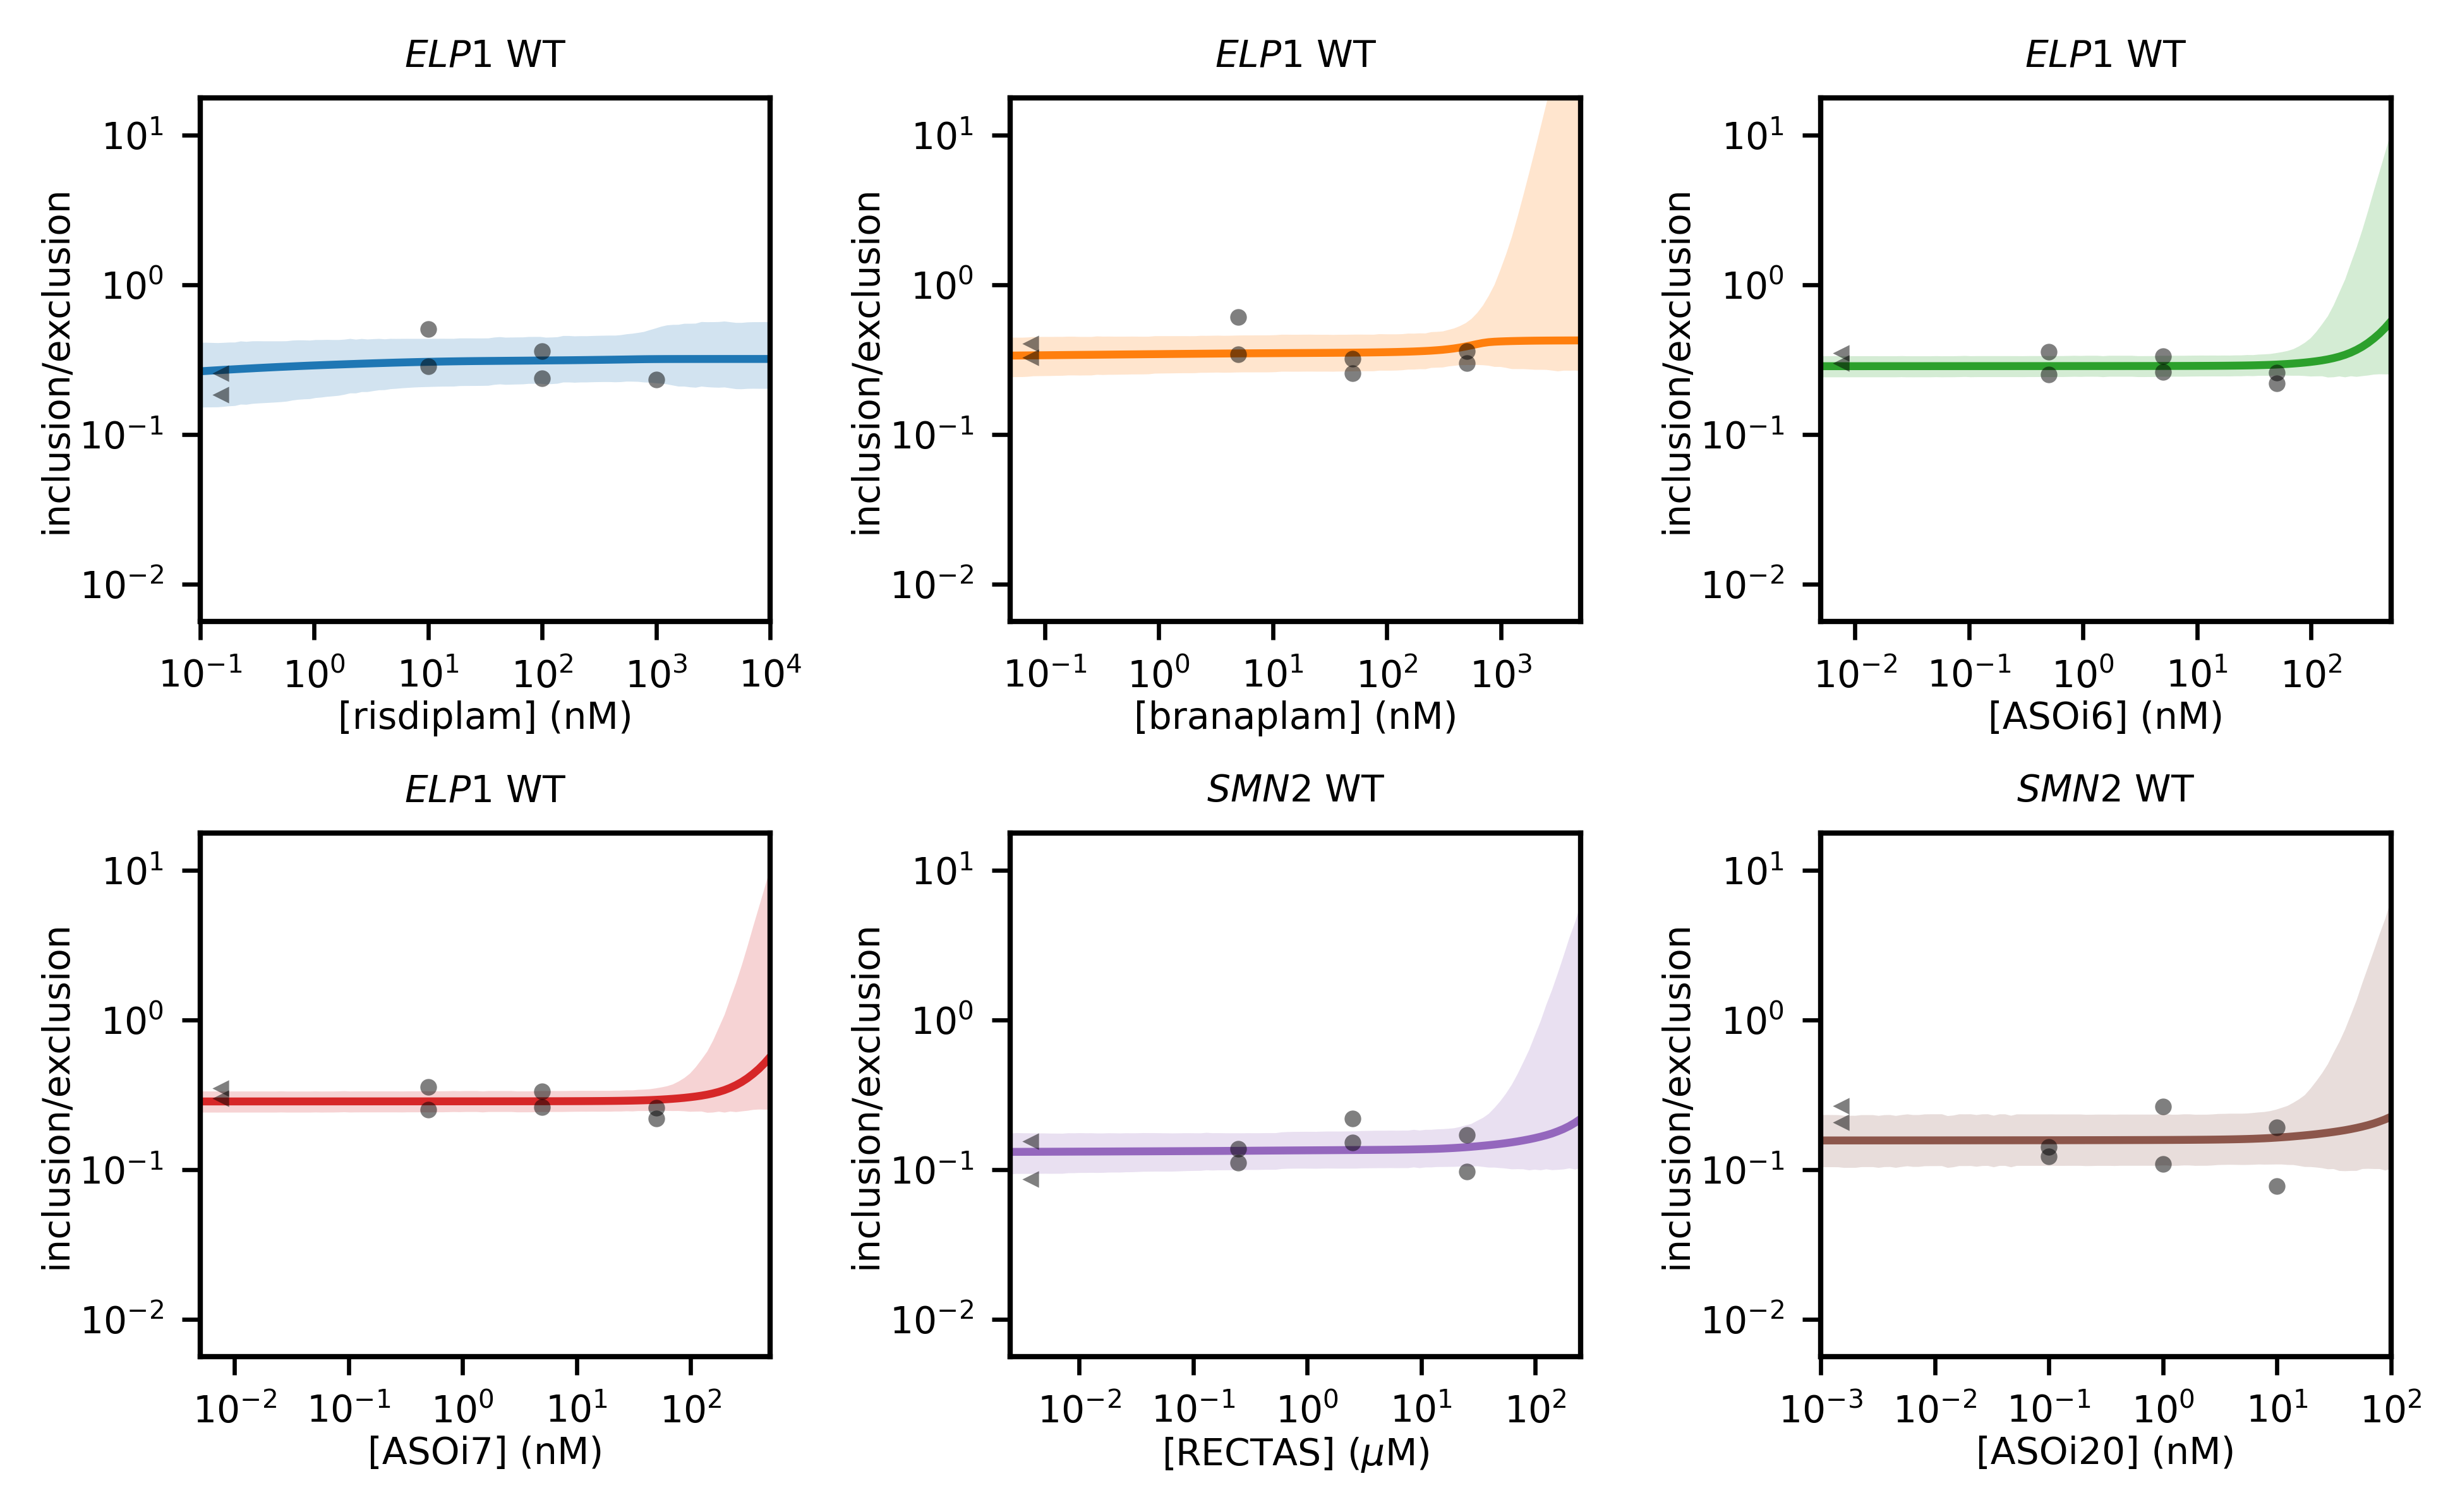

In [10]:
# FigS12
fig, axs = plt.subplots(2,3,figsize=[6.5, 4])
axs = axs.ravel()

# Define panel contents
minigenes = ['$ELP1$', '$ELP1$', '$ELP1$', '$ELP1$', '$SMN2$ WT', '$SMN2$ WT']
drugs = ['risdiplam', 'branaplam', 'ASOi6', 'ASOi7', 'RECTAS', 'ASOi20']
sheet_names = ['control_elp1_ris', 
               'control_elp1_bran', 
               'control_elp1_asoi6', 
               'control_elp1_asoi7',
               'control_smn2_rectas',
               'control_smn2_asoi20']
colors = ['C2','C3','C4','C5','C6','C7']
units = ['nM', 'nM', 'nM', 'nM', '$\mu$M', 'nM']  ## CONTINUE HERE
xlim = np.array([10**-1.0, 10**4.0])
ylim = np.array([10**-2.25, 10**1.25])

plot_single_drug(ax=axs[0],
                 minigene='$ELP1$ WT',
                 drug='risdiplam',
                 sheet_name='control_elp1_ris',
                 color='C0',
                 units='nM',
                 xlim=xlim,
                 ylim=ylim)

plot_single_drug(ax=axs[1],
                 minigene='$ELP1$ WT',
                 drug='branaplam',
                 sheet_name='control_elp1_bran',
                 color='C1',
                 units='nM',
                 xlim=xlim*.5,
                 ylim=ylim)

plot_single_drug(ax=axs[2],
                 minigene='$ELP1$ WT',
                 drug='ASOi6',
                 sheet_name='control_elp1_asoi6',
                 color='C2',
                 units='nM',
                 xlim=xlim*.05,
                 ylim=ylim)

plot_single_drug(ax=axs[3],
                 minigene='$ELP1$ WT',
                 drug='ASOi7',
                 sheet_name='control_elp1_asoi6',
                 color='C3',
                 units='nM',
                 xlim=xlim*.05,
                 ylim=ylim)

plot_single_drug(ax=axs[4],
                 minigene='$SMN2$ WT',
                 drug='RECTAS',
                 sheet_name='control_smn2_rectas',
                 color='C4',
                 units='$\mu$M',
                 xlim=xlim*.025,
                 ylim=ylim)

plot_single_drug(ax=axs[5],
                 minigene='$SMN2$ WT',
                 drug='ASOi20',
                 sheet_name='control_smn2_asoi20',
                 color='C5',
                 units='nM',
                 xlim=xlim*.01,
                 ylim=ylim)

# Save figure
fig_file = f'figS12.pdf'
fig.tight_layout(w_pad=1.25)
fig.savefig(fig_file, facecolor='white')
print(f'Plot saved to {fig_file}')